In [1]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import h5py
import pandas as pd
import os
from ipywidgets import interact, interact_manual, interactive, fixed
import matplotlib.pyplot as plt

# Proyecto Final
LAZCANO LAGOS JHONY BRANDON

El proyecto constara de entrenar una red neuronal que pueda clasificar las canciones  de acuerdo si son exitosas o no, para esto usaremos los datos que se encuentran en http://millionsongdataset.com/pages/getting-dataset/  

Los datos contienen el nombre de la cancion,el año en que salio, el tiempo de duración,etc.
Para entrenar nuestra red solo utilizaremos los siguiente:
* name: nombre de la canción

* duration: duracion de la canción

* loudness: sonoridad general de la pista

* tempo: el tiempo de la cancion medido en BPM

* time_signature: tiempos por compas

* end_f_fade_in: el tiempo en el que entra el fundido de entrada

* start_of_fade_out: el tiempo en el que entra el fundido de salida

* song_hotttnesss: popularidad de la cancion medida entre 0 y 1

## Estraccion de los datos

Extraeremos los datos que utilizaremos de los archivos y los guardaremos en datos_c

In [2]:
url="./MillionSongSubset"

In [3]:
datos_c=[]

In [4]:
#obtencion de los datos requeridos y los guardamos en datos_c
with os.scandir(url) as ficheros:
    ficheros = [fichero.name for fichero in ficheros]   
for f in ficheros:
    url_s=url+"/"+f
    with os.scandir(url_s) as ficheros_s:
        ficheros_s=[fichero_s.name for fichero_s in ficheros_s]
    for c in ficheros_s:
        url_sub=url_s+"/"+c
        with os.scandir(url_sub) as ficheros_sub:
            ficheros_sub=[fichero_sub.name for fichero_sub in ficheros_sub]
        for i in ficheros_sub:
            url_sub_s=url_sub+"/"+i
            with os.scandir(url_sub_s) as ficheros_sub_s:
                ficheros_sub_s=[fichero_sub_s.name for fichero_sub_s in ficheros_sub_s]
            for j in ficheros_sub_s:
                cancion=[]
                url_dato=url_sub_s+"/"+j
                dato= h5py.File(url_dato, 'r')
                cancion.append(dato["metadata"]["songs"][0][-2])
                cancion.append(dato["analysis"]["songs"][0][3])
                cancion.append(dato["analysis"]["songs"][0][23])
                cancion.append(dato["analysis"]["songs"][0][27])
                cancion.append(dato["analysis"]["songs"][0][28])
                cancion.append(dato["analysis"]["songs"][0][4])
                cancion.append(dato["analysis"]["songs"][0][26])
                cancion.append(dato["metadata"]["songs"][0][16])
                datos_c.append(cancion)

Veamos cuantos datos tenemos

In [16]:
len(datos_c)

10000

In [ ]:
Guardaremos nuestros datos en datos_c para usarlos posteriormente

In [6]:
with open("datos_c.pickle", "wb") as f:
    pickle.dump(datos_c, f)

In [2]:
with open("datos_c.pickle", "rb") as f:
    datos = pickle.load(f)

Veamos los datos que tenemos

In [3]:
@interact(index = (1, len(datos) - 1))
def muestradatos(index):
    print("Cancion",datos[index])

interactive(children=(IntSlider(value=5000, description='index', max=9999, min=1), Output()), _dom_classes=('w…

## Preparacion de los datos

Si observamos los datos nos podremos dar cuenta que  tenemos algunos "nan" en song_hotttnesss por lo que quitaremos estos para poder trabajar de mejor manera, además para tener una mejor interpretacion en one-hot para la clasificaremos de la popularidad clasificaremos de la siguiente manera siguiente manera:
* Si la popularidad esta entre 0 y 0.35 = 0 "Poco exitoso"
* Si la popularidad esta entre 0.35 y 0.7 = 1  "Medianamente exitoso"
* Si la popularidad esta entre  0.7 y 1= 2  "Exitoso"

In [4]:
#cambiamos el valor de song_hotttnesss y cambiamos nuestra entrada de nombre a str
nan=[]
for i,j in enumerate(datos):
    j[0]=str(j[0])
    if 0<=j[7]<0.35:
        j[7]=0
    else:
        if 0.35<=j[7]<0.7:
            j[7]=1
        else:
            if 0.7<=j[7]<=1:
                j[7]=2
            else:
                nan.append(i)

In [5]:
#eliminamos los valores nan
nan=list(reversed(nan))
for i in nan:
    datos.pop(i)

In [6]:
@interact(index = (1, len(datos) - 1))
def muestradatos(index):
    print("Cancion",datos[index])

interactive(children=(IntSlider(value=2824, description='index', max=5647, min=1), Output()), _dom_classes=('w…

Como podemos ver si teniamos demasiados datos con nan

Ahora separaremos nuestros datos en el conjunto de entrenamiento y prueba

In [7]:
datos_train,datos_test= train_test_split(datos, test_size=0.30, random_state=1)

Ahora dividiremos los datos de las entradas y salidas de la red

In [8]:
#convertimos nuestros datos en array para hacerlo más facil
datos_train=np.array(datos_train)
datos_test=np.array(datos_test)
x_train=datos_train[:,1:7]
Y_train=datos_train[:,7:]
x_test=datos_test[:,1:7]
Y_test=datos_test[:,7:]

x_train y x_test son las entradas que va a tener nuestra red.
Como haremos una clasificación entonces usaremos entropia cruzada por lo mismo necesitamos la siguiente funcion.

In [9]:
#Esta funcion nos ayudara a tener una matriz en donde la columna distinta de cero es
#nuestra etiqueta para poder usar entropia cruzada
def makeY(etiquetasEntrenamiento):
    Y=[]
    for i in range(len(etiquetasEntrenamiento)):
        y=np.zeros(3)
        y[int(etiquetasEntrenamiento[i])]=1
        Y.append(y)
    Y=np.array(Y)    
    return Y    

In [10]:
y_train=makeY(Y_train)
y_test=makeY(Y_test)
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [11]:
x_train

array([['230.53016', '-11.485', '97.004', '4', '0.368', '220.479'],
       ['230.37342', '-4.958', '102.949', '4', '0.218', '216.602'],
       ['423.07873', '-13.818', '135.599', '3', '4.725', '381.463'],
       ...,
       ['325.14567', '-8.677', '89.638', '4', '0.535', '307.217'],
       ['174.81098', '-3.235', '86.62', '4', '0.154', '169.558'],
       ['184.78975', '-10.939', '149.981', '7', '0.386', '180.814']],
      dtype='<U177')

Veamos que nuestrosdatos son de tipo str por lo que los convertiremos a tipo float para poder meterlos a la red.

In [12]:
x_train=x_train.astype(float)
x_test=x_test.astype(float)
Y_train=Y_train.astype(int)
Y_test=Y_test.astype(int)

In [13]:
x_train

array([[ 2.3053016e+02, -1.1485000e+01,  9.7004000e+01,  4.0000000e+00,
         3.6800000e-01,  2.2047900e+02],
       [ 2.3037342e+02, -4.9580000e+00,  1.0294900e+02,  4.0000000e+00,
         2.1800000e-01,  2.1660200e+02],
       [ 4.2307873e+02, -1.3818000e+01,  1.3559900e+02,  3.0000000e+00,
         4.7250000e+00,  3.8146300e+02],
       ...,
       [ 3.2514567e+02, -8.6770000e+00,  8.9638000e+01,  4.0000000e+00,
         5.3500000e-01,  3.0721700e+02],
       [ 1.7481098e+02, -3.2350000e+00,  8.6620000e+01,  4.0000000e+00,
         1.5400000e-01,  1.6955800e+02],
       [ 1.8478975e+02, -1.0939000e+01,  1.4998100e+02,  7.0000000e+00,
         3.8600000e-01,  1.8081400e+02]])

Como podemos ver nuestros datos ya son del tipo float por lo que ya estan listos para ingresarse a la red

## Definicion de la red

A continuacion definieremos la red que usaremos para clasificar los datos

Usaremos una red con una sola capa oculta y con usando la sigmoide como funcion de activacion además se normalizaran los datos para hacer el entrenamiento más rapido.

Como es un problema de clasificacion entonces usaremos entropia cruzada como función de error.

Como algoritmo de optimizacion usaremos SDG o ADAM dependiendo de cual se comporta mejor.
Por ultimo definiremos una matriz de confusion

In [14]:
class Music(nn.Module):
    def __init__(self,input_size,hidden,output_size):
        super(Music,self).__init__()
        #Definimos nuestras capas que vamos a usar y nuestra funcion de activacion
        self.W1=nn.Linear(input_size,hidden)
        self.Log=nn.Sigmoid()
        self.relu=nn.ReLU()
        self.W2=nn.Linear(hidden,output_size)
        self.norm=nn.BatchNorm1d(6)
        
    def forward(self,X):
        #transformamos nuestra entrada a un tensor float32 
        X=torch.from_numpy(X).to(torch.float32)
        if len(X)>8: 
            X=self.norm(X)
        X=self.W1(X)
        X=self.Log(X)
        X=self.W2(X)
        X=self.Log(X)
        self.salida=X
        return X
    def back_propagate(self,X,Y):
       #transformamos nuestra salida a un tensor float32 
        Y=torch.from_numpy(Y).to(torch.float32)
        #como es un problema de clasificacion entonces usaremos entropia cruzada
        Entropia=torch.nn.CrossEntropyLoss()
        error=Entropia(X,Y)
        self.error=error
    def train(self,train_X,train_Y,optimizer,ciclos=200,lr=0.01):
        #Definiremos dos algoritmos, decenso por el gradiente y adam y veremos cual se comporta mejor
        E=[]
        for i in range(ciclos):
            if optimizer==0:
                algoritmo=optim.SGD(RedMusic.parameters(), lr,momentum=0.9)
            if optimizer==1:
                algoritmo=optim.Adam(RedMusic.parameters(), lr)
            self.forward(train_X)
            self.back_propagate(self.salida,train_Y)
            algoritmo.zero_grad()
            self.error.backward()
            algoritmo.step()
            E.append(self.error.item())
        self.errores=E
        #graficamos el error
        x = np.arange(ciclos)
        plt.title("Error")
        plt.xlabel("ciclo")
        plt.scatter(x, self.errores)
        return self.error.item()
    def confusion(self,test_X,test_Y):
        #definimos nuestra matriz de confuncion
        salida=RedMusic(test_X)
        _,prediccion=torch.max(salida,0)
        salida[salida<_]=0
        salida[prediccion]=1
        salida=salida.detach().numpy()
        numElemems = test_Y.shape[0] * test_Y.shape[1]
        prediccion = salida.astype(bool)
        etiquetas = test_Y.astype(bool)
    
        matriz = np.zeros((2,2))
        TP = np.sum(np.logical_and(prediccion, etiquetas))
        matriz[0][0] = TP
    
        TN = np.logical_and(np.logical_not(prediccion), np.logical_not(etiquetas))
        matriz[1][1] = np.sum(TN)
    
        FP = np.logical_and(np.logical_not(etiquetas), prediccion)
        matriz[1][0] = np.sum(FP)
    
        FN = np.logical_and(etiquetas, np.logical_not(prediccion))
        matriz[0][1] = np.sum(FN)
    
        return matriz
        

Definimos el nombre de nuestras etiquetas

In [15]:
clases=("poco exitosa","posiblemente exitosa","exitosa")

Despues de hacer experimentos con diferentes numeros de neuronas ocultas llegamos a la conclusion que el mejor numero de neuronas es 22, como es un problema de clasificacion no necesitamos una red tan compleja por lo que no se vio necesario agregar otra capa oculta.

## Entrenamiento

### Entrenamiento con SDG

In [16]:
#Veamos como se comporta SDG
RedMusic=Music(6,22,3)

1.0445959568023682

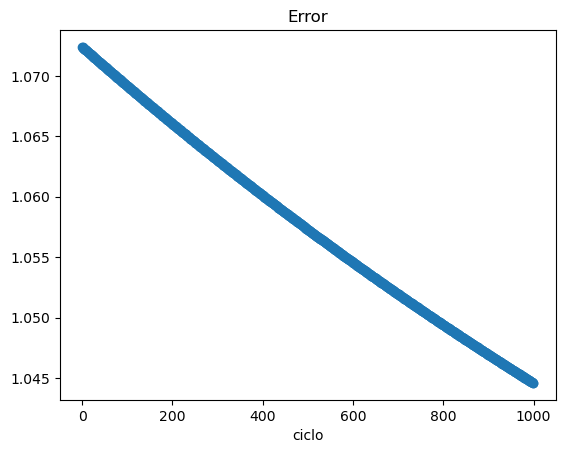

In [17]:
RedMusic.train(x_train,y_train,optimizer=0,ciclos=1000,lr=0.001)

### Entrenamiento con ADAM

In [31]:
#Veamos como se comporta ADAM
RedMusic=Music(6,22,3)
#4100
#0.9097223281860352
#0.001 y desoues 0.01
#3000 ciclos
#0.8933736681938171

0.9205262064933777

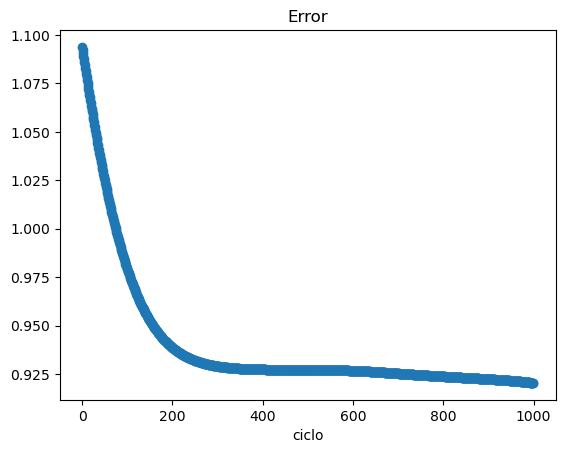

In [32]:
RedMusic.train(x_train,y_train,optimizer=1,ciclos=1000,lr=0.001)

Como podemos ver  se comporta mejor el algoritmo ADAM por lo que usaremos este

## Mejorando el entrenamiento

Cambiaremos el valor de lr para reducir el error

Entrenaremos 3000 ciclos más con lr=0.001

0.8984689116477966

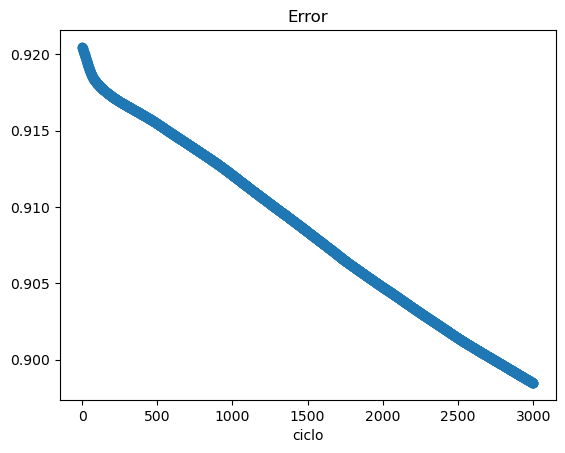

In [33]:
RedMusic.train(x_train,y_train,optimizer=1,ciclos=3000,lr=0.001)

Entrenaremos 6000 ciclos con lr=0.01

0.8981698155403137

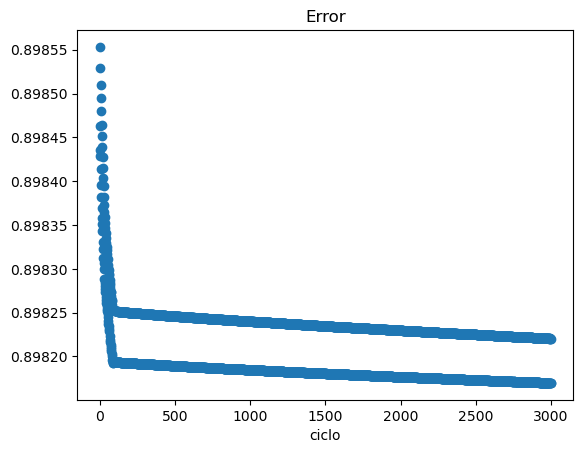

In [34]:
RedMusic.train(x_train,y_train,optimizer=1,ciclos=3000,lr=0.01)

Entrenaremos otros 3000 ciclos para lr=0.1

0.8884148001670837

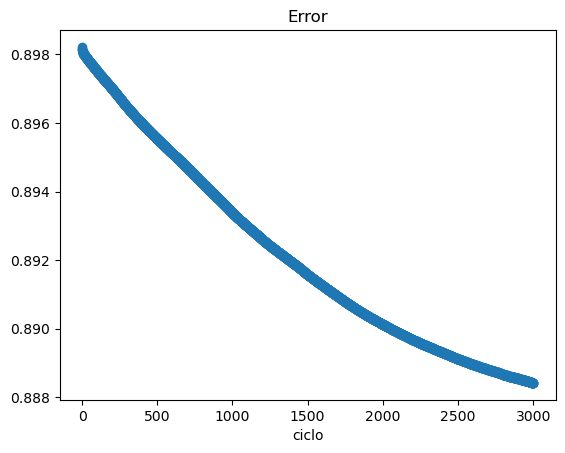

In [35]:
RedMusic.train(x_train,y_train,optimizer=1,ciclos=3000,lr=0.001)

In [38]:
#Gurdamos los datos de nuestra red entrenada
PATH = './Music.pth'
torch.save(RedMusic.state_dict(), PATH)

## Resultados

### Datos de entrenamiento

Veamos que nos dice la matriz de confusion

In [39]:
#Definimos nuestra matriz de confusion
def matrizdeconfusion(red,x_train,y_train):
    #Obtenemos la matriz de confusion de cada etiqueta
    for j in range(3):
        predicciones=[]
        etiquetas=[]
        for i in range(len(y_train)):
            etiqueta=y_train[i]
            salidas=red(x_train[i])
            _, prediccion=torch.max(salidas,0)
            prediccion=int(prediccion)
            #Pasamos por cada elemento de y_test y agregamos un 1 a etiquetas si es la etiqueta que necesitamos y 0 en otro caso, de mismo modo para predicciones 
            if etiqueta[0]==j:
                etiquetas.append(1)
            else:
                etiquetas.append(0)
            if prediccion==j:
                predicciones.append(1)    
            else:
                predicciones.append(0)
        #Obtenemos nuestra matriz de forma tradicional            
        prediccion =np.array(predicciones).astype(bool)
        etiquetas = np.array(etiquetas).astype(bool)
    
        matriz = np.zeros((2,2))
        TP = np.sum(np.logical_and(prediccion, etiquetas))
        matriz[0][0] = TP
    
        TN = np.logical_and(np.logical_not(prediccion), np.logical_not(etiquetas))
        matriz[1][1] = np.sum(TN)
    
        FP = np.logical_and(np.logical_not(etiquetas), prediccion)
        matriz[1][0] = np.sum(FP)
    
        FN = np.logical_and(etiquetas, np.logical_not(prediccion))
        matriz[0][1] = np.sum(FN)
        print("Matriz",clases[j])
        print( matriz)
                  

In [40]:
RedMusic.confusion(x_train,y_train)

array([[2181., 1772.],
       [1852., 6054.]])

Ahora veremos que pasa con la matriz de confusion de cada etiqueta

In [41]:
matrizdeconfusion(RedMusic,x_train,Y_train)

Matriz poco exitosa
[[ 575. 1378.]
 [ 592. 1408.]]
Matriz posiblemente exitosa
[[1219.  523.]
 [1567.  644.]]
Matriz exitosa
[[   0.  258.]
 [   0. 3695.]]


Veamos la etiqueta y prediccion de cada elemento.

In [42]:
@interact(index = (1, len(x_train) - 1))
def muestrared(index):
    salida=RedMusic(x_train[index])
    _,prediccion=torch.max(salida,0)
    print("Prediccion:", clases[prediccion])
    print("Etiqueta:", clases[Y_train[index][0]])

interactive(children=(IntSlider(value=1976, description='index', max=3952, min=1), Output()), _dom_classes=('w…

### Datos de prueba 

Matriz de datos de prueba

In [43]:
RedMusic.confusion(x_test,y_test)

array([[ 924.,  771.],
       [ 827., 2563.]])

Ahora veremos que pasa con la matriz de confusion de cada etiqueta

In [44]:
matrizdeconfusion(RedMusic,x_test,Y_test)

Matriz poco exitosa
[[239. 574.]
 [265. 617.]]
Matriz posiblemente exitosa
[[540. 238.]
 [651. 266.]]
Matriz exitosa
[[   0.  104.]
 [   0. 1591.]]


Veamos la etiqueta y prediccion de cada elemento.

In [45]:
@interact(index = (1, len(x_test) - 1))
def muestrared(index):
    salida=RedMusic(x_test[index])
    _,prediccion=torch.max(salida,0)
    salida[salida<_]=0
    salida[prediccion]=1
    print("Prediccion:", clases[prediccion])
    print("Etiqueta:", clases[Y_train[index][0]])

interactive(children=(IntSlider(value=847, description='index', max=1694, min=1), Output()), _dom_classes=('wi…

## Conclusiones

Despues de haber entrenado nuestra red y observar las matrices de confusion podemos ver que la red no reconoce a las canciones exitosas, esto puede ser porque hay muy pocos datos con esta etiqueta, por lo que necesitamos un mayor número de datos para clasificar de mejor manera. 

Por otra parte podemos ver que clasifica de buena manera a  las poca exitosas y posiblemente exitosas .

Veamos que pasa si introducimos datos de canciones actuales

In [61]:
canciones=np.array([["Ella baila sola",245,-5,95,3,2,241],
                    ["BZRP-Peso Pluma",308,-5,130,3,6,300],
                   ["where she goes",352,-4,105,4,11,242],
                   ["un x100to",315,-4.5,88,2,13,304],
                   ["cupid",254,-5.5,96,4,8,251],
                   ["Jingo",515,-4,70,3,10,511],
                   ["Lupita",401,-6,89,4,1,394],
                   ["Hold the line",401,-5.5,100,4,1,354],
                   ["Elemento",326,-4,105,4,1,323],
                   ["This boy",216,-4,75,4,1,205]])

In [62]:
E_canciones=canciones[:,1:]
E_canciones=E_canciones.astype(float)
E_canciones

array([[245. ,  -5. ,  95. ,   3. ,   2. , 241. ],
       [308. ,  -5. , 130. ,   3. ,   6. , 300. ],
       [352. ,  -4. , 105. ,   4. ,  11. , 242. ],
       [315. ,  -4.5,  88. ,   2. ,  13. , 304. ],
       [254. ,  -5.5,  96. ,   4. ,   8. , 251. ],
       [515. ,  -4. ,  70. ,   3. ,  10. , 511. ],
       [401. ,  -6. ,  89. ,   4. ,   1. , 394. ],
       [401. ,  -5.5, 100. ,   4. ,   1. , 354. ],
       [326. ,  -4. , 105. ,   4. ,   1. , 323. ],
       [216. ,  -4. ,  75. ,   4. ,   1. , 205. ]])

In [64]:
for i in E_canciones:
    salida=RedMusic(i)
    _,prediccion=torch.max(salida,0)
    print("Prediccion:", clases[prediccion])

Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa
Prediccion: posiblemente exitosa


Todas las canciones nos las marca como posibles exitos y por las canciones que se tomaron podemos ver que esta respondiendo de manera correcta la red